### All-sky AME vs. IR Scatter Plots

In [1]:
#from IPython.external import mathjax; mathjax.install_mathjax()
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import healpy.projector as pro
import astropy.io.fits as fits
from scipy.stats import gaussian_kde
import scipy
import pandas as pd
import pickle
matplotlib.style.use('seaborn-bright')
%matplotlib inline

# 0.1) Load data and masks:

In [2]:
with open('../Data/maps_nest.pickle') as f:  # Python 3: open(..., 'rb')
    coords, planck_bb, planck_mw,  phot, phot_modesub, phot_mpsub = pickle.load(f)
    



In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler


### Setup the standard pipeline to apply to all the data:
allsky_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler(with_mean=False)),
])
# allsky_pipeline = Pipeline([
#     ('imputer', Imputer(strategy="median"))
# ])

phot_tr      = pd.DataFrame(allsky_pipeline.fit_transform(phot),columns=phot.columns)
planck_bb_tr = pd.DataFrame(allsky_pipeline.fit_transform(planck_bb),columns=planck_bb.columns)
planck_mw_tr = pd.DataFrame(allsky_pipeline.fit_transform(planck_mw),columns=planck_mw.columns)




### 1.1) Cross-correlation among all IR photometric bands and AME map
##### Split by Galactic Latitude

In [4]:
glatrange     = 10.0
elatrange     = 5


gcut_l = np.where(
    (abs(coords['glat']) < glatrange) & 
    (abs(coords['elat']) > elatrange)
    )

gcut_h = np.where(
    (abs(coords['glat']) > glatrange) & 
    (abs(coords['elat']) > elatrange)
)



In [5]:
import seaborn as sb


In [6]:
def plotCorrMatrix(mapframe, pdf_suffix):
    
    mapframe_corr     = mapframe.corr(method='spearman')
    mapframe_corr_lgl = mapframe.iloc[gcut_l].corr(method='spearman')
    
    mask = np.zeros_like(mapframe_corr.values)
    mask[np.triu_indices_from(mask,k=1)] = True

    with sb.axes_style("white"):


        fig, ax = plt.subplots(1,2,figsize=(14,7))
        cbar_ax = fig.add_axes([.91, .2, .03, .7])

        sb.heatmap(
            mapframe_corr,
            #linewidths=.5,
            annot=True,
            mask=mask,
            cbar=False,
            yticklabels=True,
            xticklabels=True,
            ax = ax[0],
            vmin=0,
            vmax=1)

        ax[0].set_title("Whole-sky", fontsize=20)

        sb.heatmap(
            mapframe_corr_lgl,
            #linewidths=.5,
            annot=True,
            mask=mask,
            cbar=True,
            cbar_ax=cbar_ax,
            yticklabels=True,
            xticklabels=True,
            ax=ax[1],
            vmin=0,
            vmax=1,
            cbar_kws={'label': 'Spearman $r$'})

        ax[1].set_title("$|b| < 10^{\circ}$", fontsize=20)

        #cbar_ax.set_title("Spearman $r$")
        fig.tight_layout(rect=[0, 0, .9, 1])

        plt.show()

        fig.savefig("../Plots/all_bands_corr_matrix_wAME_spearman{}.pdf".format(pdf_suffix), bbox_inches='tight')
        fig.savefig("../Plots/png/all_bands_corr_matrix_wAME_spearman{}.png".format(pdf_suffix), bbox_inches='tight')
       


Now we compare the spearman correlation scores among all of the IR bands, and the AME. We do this for for 3 different cases: 

  * Intensity
  * Intensity / U
  * Intensity / R 

In [7]:
# Cross-correlation: Intensity vs. AME and Dust Radiance

/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


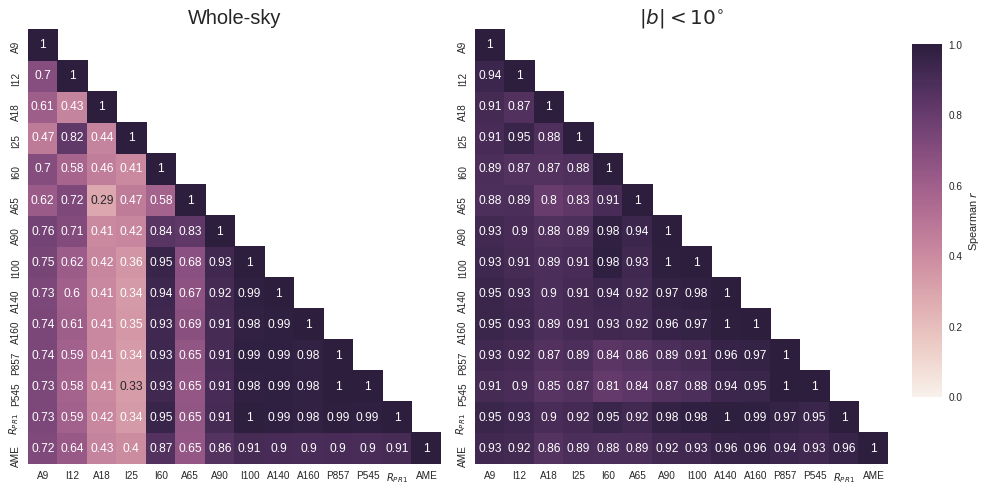

In [8]:
plotCorrMatrix(
    phot_mpsub.join(
        planck_bb['$R_{PR1}$']).join(planck_mw['AME']
                ),
    pdf_suffix = 'intensity'
               )

#### Cross-correlation: MIR/U Bands vs. AME/U and R/U

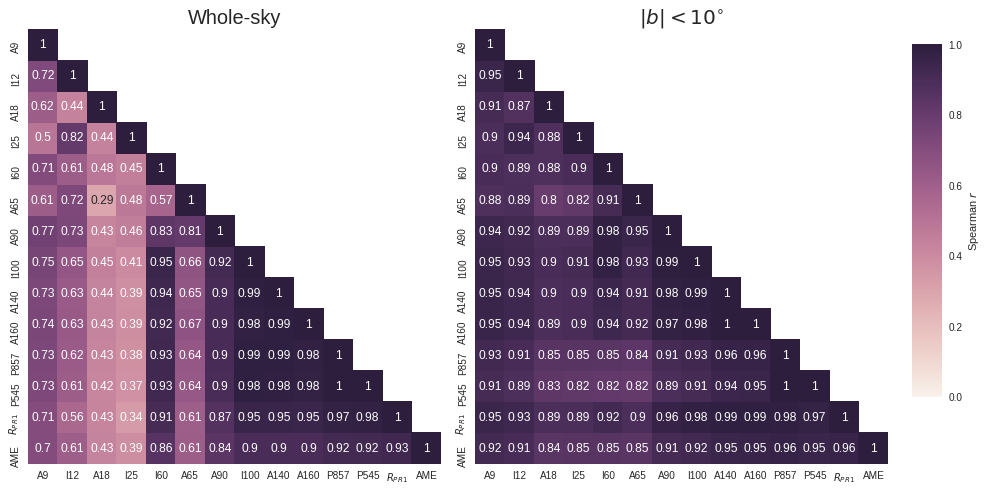

In [11]:
plotCorrMatrix(  
                (
                    phot_mpsub.join(
                    planck_bb['$R_{PR1}$']).join(
                        planck_mw['AME'])
                ).divide(
                    planck_bb['$U$'], axis=0),
                pdf_suffix = 'U_norm'
               )

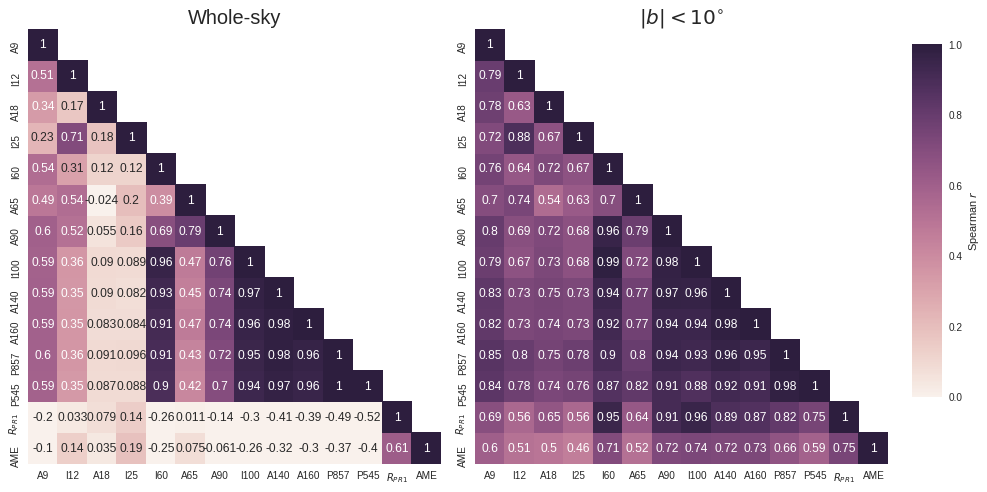

In [10]:
plotCorrMatrix(  
                (
                    phot_mpsub.join(
                    planck_bb['$R_{PR1}$']).join(
                        planck_mw['AME'])
                ).divide(
                    planck_bb['$\tau_{353,PR1}$'], axis=0),
                pdf_suffix = 'tau_norm'
               )

# All-sky AME vs. IR plots:

In [13]:
def plotBandsCloud(xframe, yseries, xlabel, ylabel, xylims, outpath, nside=256):
    
    sb.set_style("whitegrid")

    ncols=4
    nrows=3
    aspect=1.0

    fig, axs = plt.subplots(ncols=ncols, 
                            nrows=nrows, 
                            sharey=True, 
                            sharex=True)
    #fig.subplots_adjust(hspace=0.1, left=0.1, right=0.7)
    plt.setp(axs.flat, aspect=1.0, adjustable='box-forced')

    k=0

    hsize = hp.nside2npix(nside)
    
    randsub = np.random.randint(low=0, high=hsize, size=hsize//50)


    for i in range(0,nrows):
        for j in range(0,ncols):
                
                #print k
                
                if k > 11:

                    pass

                else:

                    x = xframe[xframe.columns[k]].iloc[randsub]


                    y = yseries.iloc[randsub]

                    x_ = x[(x>0) & (y>0) & (np.isfinite(x)==True) & (np.isfinite(y)==True)].copy()
                    y_ = y[(x>0) & (y>0) & (np.isfinite(x)==True) & (np.isfinite(y)==True)].copy()

                    x_ = np.log10(x_).values
                    y_ = np.log10(y_).values

                    ax = axs[i,j]

                    sb.kdeplot(
                           x_,
                           y_,
                           shade=True,
                           shade_lowest=False,
                           gridsize=100,
                            ax = ax)



                    #ax.axis([xmin, xmax, ymin, ymax])
                    ax.axis(xylims)

                    ax.text(0.2, 0.9,xframe.columns[k], horizontalalignment='center',
                      verticalalignment='center',
                      transform=ax.transAxes, 
                      fontsize=15)

                    ax.grid(True)

                    ax.set_frame_on(True)

                    k += 1
                    
        ax = axs[-1,0]
        ax.set_ylabel(ylabel, fontsize=15)
        ax = axs[-1,0]
        ax.set_xlabel(xlabel, fontsize=15)

        plt.show()

        fig.savefig(outpath, bbox_inches='tight')
        fig.savefig(outpath[:-4]+".png", bbox_inches='tight')

                    
    return axs
    


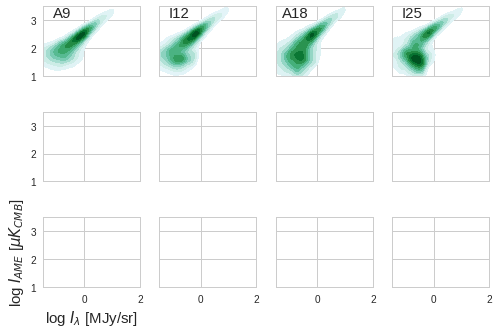

In [14]:
axs = plotBandsCloud(
                xframe = phot_mpsub, 
               yseries = planck_mw['AME'],
                ylabel = 'log $I_{AME}$ [$\mu{}K_{CMB}$]',
                xlabel = 'log $I_{\lambda}$ [MJy/sr]',
                xylims = [-1.5,2,1,3.5],
                outpath = "../Plots/AMEvsDust_allsky_allbands__mpsub_kde.pdf"
)

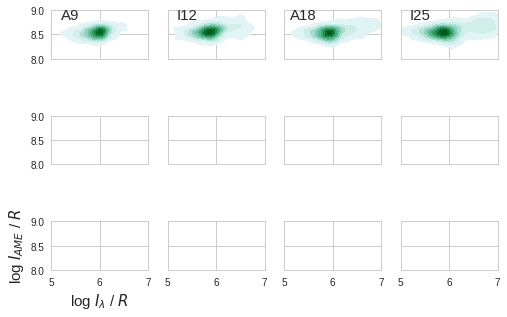

KeyboardInterrupt: 

In [91]:
xframe = phot_mpsub.divide(planck_bb['$R_{PR1}$'], axis=0)
yseries = planck_mw['AME'].divide(planck_bb['$R_{PR1}$'], axis=0)
axs = plotBandsCloud(
                xframe = xframe, 
               yseries = yseries,
                ylabel = 'log $I_{AME}$ / $R$',
                xlabel = 'log $I_{\lambda}$ / $R$ ',
                xylims = [5,7,8,9],
                outpath = "../Plots/AMEvsDust_allsky_allbands__mpsub_Rnorm_kde.pdf"
)

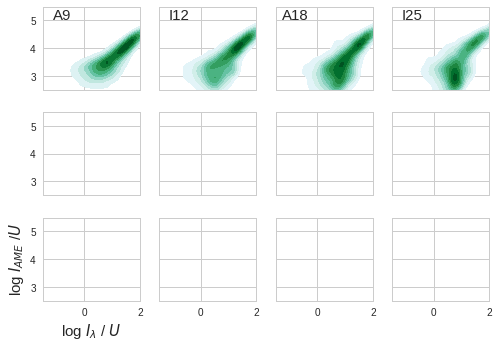

In [17]:
axs = plotBandsCloud(
                xframe = phot_mpsub.divide(planck_bb['$U$'], axis=0), 
               yseries = planck_mw['AME'].divide(planck_bb['$U$'], axis=0),
                ylabel = 'log $I_{AME}$ /$U$',
                xlabel = 'log $I_{\lambda}$ / $U$',
                xylims = [-1.5,2,2.5,5.5],
                outpath = "../Plots/AMEvsDust_allsky_allbands_mpsub_UNorm_kde.pdf"
)

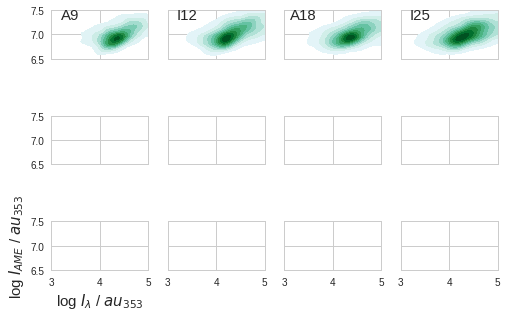

In [21]:
axs = plotBandsCloud(
                xframe = phot_mpsub.divide(planck_bb['$\tau_{353,PR1}$'], axis=0), 
               yseries = planck_mw['AME'].divide(planck_bb['$\tau_{353,PR1}$'], axis=0),
                ylabel = 'log $I_{AME}$ / $\tau{}_{353}$',
                xlabel = 'log $I_{\lambda}$ / $\tau{}_{353}$',
                xylims = [3,5,6.5,7.5],
                outpath = "../Plots/AMEvsDust_allsky_allbands__mpsub__tauNorm_kde.pdf"
)

In [ ]:
## Check correlations, adding 10% noise after removal of first principal component

In [ ]:
def testSpatialCorr(df, 
                    nside_in, 
                    nside_out,
                    method='spearman'):
    
    npix_in    = 12*nside_in**2
    npix_out   = 12*nside_out**2
    pix_interv = (nside_in/nside_out)**2
    
    ## First, do it the "normal way"-
    patches_corr = [df.iloc[i*pix_interv:(i+1)*pix_interv].corr(method=method) for i in range(0,npix_out)]
    corr_patches_pn = pd.Panel({i: patches_corr[i] for i in range(0,npix_out)})

    
    return corr_patches_pn

def displaySpatialCorr(corr_patches_pn,labels, ref_col=0,subdir='../Plots/Allsky_Corr/'):

    nside = len(corr_patches_pn.values[:,0,0])
    #fig = plt.figure(figsize=(8,4))

    for j in range(0,len(labels)):
        #plt.subplot(2,5,(j*2)+1)
        hp.mollview(corr_patches_pn.values[:,j,ref_col],
                         #sub=(1,4,j+1), 
                         #fig=fig,
                         cmap = "rainbow", 
                         cbar = False, 
                         min  = -1, 
                         max  = 1, 
                         nest = True, 
                         title="$S$({}:{}) NSIDE".format(labels[ref_col],labels[j],nside_out))
        hp.graticule(dpar=5, dmer=5,coord='G')
        
        plt.savefig("{}/Spearman_Map_nside{}_{}to{}.pdf".format(subdir,nside_out,labels[ref_col],labels[j]) )

In [ ]:
# Makes all the correlation maps
for i in range(0,len(test_frame.columns)):
    displaySpatialCorr(corr_patches_pn, test_frame.columns, ref_col = i)

In [ ]:
nside_in = 256
nside_out = 8
test_frame_RadNorm = phot_mpsub.join(planck_mw['AME']).divide(planck_bb['$R_{PR1}$'], axis=0)
corr_patches_pn_RadNorm = testSpatialCorr(test_frame_RadNorm,
                                  nside_in, 
                                  nside_out)

In [ ]:
for i in range(0,len(test_frame_RadNorm.columns)):
    displaySpatialCorr(corr_patches_pn_RadNorm, test_frame_RadNorm.columns, ref_col = i,
                                  subdir='../Plots/Allsky_Corr/UNorm')

In [ ]:
nside_in = 256
nside_out = 8
test_frame_UNorm = phot_mpsub.join(planck_mw['AME']).divide(planck_bb['$U$'], axis=0),
corr_patches_pn_UNorm = testSpatialCorr(test_frame_UNorm,
                                  nside_in, 
                                  nside_out)

In [ ]:
for i in range(0,len(test_frame_UNorm.columns)):
    displaySpatialCorr(corr_patches_pn_UNorm, test_frame_UNorm.columns, ref_col = i,
                                  subdir='../Plots/Allsky_Corr/UNorm')

In [7]:
# All-sky Ionization fraction:
phot_mir_ratios = phot_mpsub.drop(['A9']).join(planck_bb['$R_{PR1}$']).join(planck_mw['$R_{PR1}$']).divide(phot_mpsub.A9)
   

NameError: name 'phot_mpsub' is not defined

In [ ]:
# The check appears successful, so make a plot grid of all the nsides:

## All-sky Noise Estimation:

In [ ]:
hmap_hists =  pd.DataFrame.hist(phot_modesub, 
                                range=(-10, 25), 
                                bins=100, 
                                alpha=0.4, 
                                grid=True,
                                sharex=True, 
                                xlabelsize=15,
                                sharey=False,
                                ylabelsize=12,
                                figsize=(11,8.5),
                                **{'normed':True})
hmap_hists

In [ ]:
def plot_hdists(df):
    
    import seaborn as sns
    import scipy.stats as stats
    sns.distplot(df, bins=1000, kde=False, fit=stats.gamma )
    print 
    
plot_hdists(phot_modesub[(phot_modesub>-5) & (phot_modesub<25)].A9.dropna())

In [ ]:
data = phot_modesub.dropna().values[:,0]
# phot_modesub[(phot_modesub>-5) & (phot_modesub<25)].A9.dropna()
# data.std()


In [ ]:
from astropy.modeling import models, fitting

def fitAndPlot(data, ymax=2.0, nbins=1000, amplitude =1, stddev = 1, mean=0, zero_mean=False, left_wing=False, left_mean=False, xrange=(-10,10)):
    

    # Get distribution
    y,x, patches = plt.hist(data, range=xrange, bins=nbins, normed=True,alpha=0.8)
    #print y
    # Fit the data using a Gaussian
    g_init = models.Gaussian1D(amplitude=amplitude, mean=mean, stddev=stddev)
    g_init.mean.fixed = zero_mean
    g_init.stddev.bounds = (0,None)
    fit_g = fitting.LevMarLSQFitter()
    
    if left_wing == True:
        g = fit_g(g_init, x[:-1][x[:-1]<0], y[x[:-1]<0])
    elif left_mean == True:
        g = fit_g(g_init, x[:-1][x[:-1]<np.mean(data)], y[x[:-1]<np.mean(data)])
    else:
        g = fit_g(g_init, x[:-1], y)



    plt.plot(x,g(x),label='Gaussian', color='black',alpha=0.8)



    # Plot the data with the best-fit model
    # plt.figure(figsize=(8,5))
    # plt.plot(x, y[:-1], 'ko')
    # plt.plot(x, g(x), label='Gaussian')
    plt.ylim(0,ymax)
    plt.ylabel('Norm. Pixel Count', fontsize=22)
    plt.xlabel('Intensity [MJy/sr]',fontsize=22)
    plt.legend(loc=2)
    plt.text((xrange[1]-abs(xrange[0])*3)/8,ymax/4,"Stddev: "+str(round(g.stddev.value,3)),fontsize=22)
    plt.text((xrange[1]-abs(xrange[0])*3)/8,(ymax*5)/8,"Data mean: "+str(round(np.mean(data),3)),fontsize=22)
    
    return g.stddev.value

# fitAndPlot(data)
# plt.show()
# plt.close()
# fitAndPlot(data, zero_mean=True)
# plt.show()
# plt.close()
# fitAndPlot(data, zero_mean=False, left_wing=True)
# plt.show()
# plt.close()
fitAndPlot(data, left_mean=True)
plt.show()
plt.close()
    
# Select data

In [ ]:
# Get distribution
y,x, patches = plt.hist(planck_mw.AME.dropna().values-0, range =(-30,150),bins=1000, normed=True,alpha=0.8)
#print y
# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=0, stddev=1.)
g_init.mean.fixed = False
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x[:-1][x[:-1]<0], y[x[:-1]<0])

plt.plot(x,g(x),label='Gaussian', color='black')

plt.ylabel('Norm. Pixel Count', fontsize=22)
plt.xlabel('Intensity [uKCMB]',fontsize=22)
plt.legend(loc=2)


print np.size(planck_mw.AME.dropna()==0)

In [ ]:
# Get distribution
y,x, patches = plt.hist(planck_bb['$T$'].dropna().values, range =(0,50),bins=100, normed=True,alpha=0.8)
#print y
# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=0.1, mean=20, stddev=1.)
g_init.mean.fixed = False
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x[:-1], y)

plt.plot(x,g(x),label='Gaussian', color='black')



# Plot the data with the best-fit model
# plt.figure(figsize=(8,5))
# plt.plot(x, y[:-1], 'ko')
# plt.plot(x, g(x), label='Gaussian')
#plt.ylim(0,2.0)
plt.ylabel('Norm. Pixel Count', fontsize=22)
plt.xlabel('Intensity [uKCMB]',fontsize=22)
plt.legend(loc=2)
#plt.text(60,0.008,"Stddev: "+str(round(g.stddev.value,3)),fontsize=22)
#plt.text(60,0.006,"Data mean: "+str(round(np.mean(data),3)),fontsize=22)

#print np.size(planck_mw.T.dropna()==0)

In [ ]:
## Whole sky without mean-fixing or wing-selection

In [ ]:
stddevs = []
for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub.dropna().values[:,i]
    stddev = fitAndPlot(data)
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+".pdf", bbox_inches='tight', dpi=100)
    plt.show()
 

In [ ]:
## Whole sky with mean fixed to zero, using only the left wing

In [ ]:
stddevs = []

for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub.dropna().values[:,i]
    stddev = fitAndPlot(data, zero_mean=True, left_wing=True)
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_leftWing_zeroMean.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()
 

## Noise estimated for limited patches:

#### Patch 1: (l:130, b:60) [25x25 degree Gal] , npix = 20164

In [ ]:
stddevs = []

noise_patches = [(coords.glon > 117.5) & (coords.glon < 142.5) & (coords.glat > 47.5) & (coords.glat < 72.5),
                 (coords.glon > 217.5) & (coords.glon < 242.5) & (coords.glat < -47.5) & (coords.glat > -72.5),
                 (coords.glon > 217.5) & (coords.glon < 242.5) & (coords.glat > 47.5) & (coords.glat < 72.5)]

for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub[noise_patches[0]].dropna().values[:,i]
    # Using an initial stddev of 1 seems to lead to underfitting, here- using 0,5 instead
    stddev = fitAndPlot(data,
                        amplitude=2, 
                        mean=np.mean(data), 
                        ymax=7, 
                        stddev = 0.1, 
                        zero_mean=False, 
                        left_wing=False,
                        left_mean=False,                        
                        nbins=400, 
                        xrange=(-4,4))
    
    
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_noisePatch1.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()
 

#### Patch 2: (l:230, b:-60) [25x25 degree Gal] , npix = 20164

In [ ]:
for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub[noise_patches[1]].dropna().values[:,i]
    # Using an initial stddev of 1 seems to lead to underfitting, here- using 0,5 instead
    stddev = fitAndPlot(data,
                        amplitude=2, 
                        mean=np.mean(data), 
                        ymax=7, 
                        stddev = 0.1, 
                        zero_mean=False, 
                        left_wing=False, 
                        nbins=1000, 
                        xrange=(data.min(),data.max()))
    
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_leftWing_zeroMean_noisePatch2.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()

#### Patch 3: (l:230, b:60) [25x25 degree Gal] , npix = 20164

In [ ]:
for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub[noise_patches[2]].dropna().values[:,i]
    # Using an initial stddev of 1 seems to lead to underfitting, here- using 0,5 instead
    stddev = fitAndPlot(data,
                        amplitude=2, 
                        mean=np.mean(data), 
                        ymax=7, 
                        stddev = 0.1, 
                        zero_mean=False, 
                        left_wing=False, 
                        nbins=1000, 
                        xrange=(data.min(),data.max()))
    
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_leftWing_zeroMean_noisePatch3.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()

In [ ]:
#### All 3 patches merged together:

noise_patches_merged = ((coords.glon > 117.5) & (coords.glon < 142.5) & (coords.glat > 47.5) & (coords.glat < 72.5)) | \
                 ((coords.glon > 217.5) & (coords.glon < 242.5) & (coords.glat < -47.5) & (coords.glat > -72.5)) | \
                 ((coords.glon > 217.5) & (coords.glon < 242.5) & (coords.glat > 47.5) & (coords.glat < 72.5) )


for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub[noise_patches_merged].dropna().values[:,i]
    # Using an initial stddev of 1 seems to lead to underfitting, here- using 0,5 instead
    stddev = fitAndPlot(np.random.choice(data, size=len(noise_patches_merged)//1),
                        amplitude=2, 
                        mean=np.mean(data), 
                        ymax=7, 
                        stddev = 0.1, 
                        zero_mean=False, 
                        left_mean=False,                        
                        nbins=1000, 
                        xrange=(data.min(),5))
    
    stddevs.append(stddev)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_leftWing_zeroMean_noisePatchMerged.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()

## Estimate noise for a limited part of the sky: Planck CMB Mask

#### Masking test

In [ ]:
data =  phot_modesub.A9.values.copy
hp.mollview(data)
print len(data[np.isnan(data)==True])
hmask = hp.read_map('/work1/users/aaronb/Codebrary/Python/Projects/LOrionis/data/raw/healpix/referenceMaps/COM_Mask_CMB-IQU-common-field-MaskInt_0256.fits')
data[hmask==hp.UNSEEN] = np.nan
print len(data[np.isnan(data)==True])
print len(hmask[hmask==hp.UNSEEN])

In [ ]:
from astropy.modeling import models, fitting

def fitAndPlotMaskedTest(data,zero_mean=False, left_wing=False, left_mean=False):
    
    hp.mollview(data.values)
    plt.show()
    plt.close()
    
    data_unmask = data.copy()
    data_mask   = data.copy()
    
    data_unmask = data_unmask.dropna().values

    # Get distribution

    y,x, patches = plt.hist(data_unmask, range=(-10, 10), bins=1000, normed=True,alpha=0.8)
    #print y
    # Fit the data using a Gaussian
    g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
    g_init.mean.fixed = zero_mean
    fit_g = fitting.LevMarLSQFitter()
    
    if left_wing == True:
        g = fit_g(g_init, x[:-1][x[:-1]<0], y[x[:-1]<0])
    elif left_mean == True:
        g = fit_g(g_init, x[:-1][x[:-1]<np.median(data_unmask)], y[x[:-1]<np.median(data_unmask)])
    else:
        g = fit_g(g_init, x[:-1], y)



    plt.plot(x,g(x),label='Gaussian', color='black')



    # Plot the data with the best-fit model
    # plt.figure(figsize=(8,5))
    # plt.plot(x, y[:-1], 'ko')
    # plt.plot(x, g(x), label='Gaussian')
    plt.ylim(0,2.0)
    plt.ylabel('Norm. Pixel Count', fontsize=22)
    plt.xlabel('Intensity [MJy/sr]',fontsize=22)
    plt.legend(loc=2)
    plt.text(0.75,0.5,"Stddev: "+str(round(g.stddev.value,5)),fontsize=22)
    plt.text(0.75,0.75,"Data mean: "+str(round(np.mean(data_unmask),5)),fontsize=22)
    plt.show()
    plt.close()
    
    # Mask pixels from the degraded Planck Foreground Mask Map:
    hmask = hp.read_map('/work1/users/aaronb/Codebrary/Python/Projects/LOrionis/data/raw/healpix/referenceMaps/COM_Mask_CMB-IQU-common-field-MaskInt_0256.fits')


    data_mask[hmask==hp.UNSEEN] = np.nan
    hp.mollview(data_mask)
    plt.show()
    plt.close()
    
    y,x, patches = plt.hist(data_mask, range=(-10, 10), bins=1000, normed=True,alpha=0.8)
    #print y
    # Fit the data using a Gaussian
    g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
    g_init.mean.fixed = zero_mean
    fit_g = fitting.LevMarLSQFitter()
    
    if left_wing == True:
        g = fit_g(g_init, x[:-1][x[:-1]<0], y[x[:-1]<0])
    elif left_mean == True:
        g = fit_g(g_init, x[:-1][x[:-1]<np.median(data_mask)], y[x[:-1]<np.median(data_mask)])
    else:
        g = fit_g(g_init, x[:-1], y)



    plt.plot(x,g(x),label='Gaussian', color='black')



    # Plot the data with the best-fit model
    # plt.figure(figsize=(8,5))
    # plt.plot(x, y[:-1], 'ko')
    # plt.plot(x, g(x), label='Gaussian')
    plt.ylim(0,2.0)
    plt.ylabel('Norm. Pixel Count', fontsize=22)
    plt.xlabel('Intensity [MJy/sr]',fontsize=22)
    plt.legend(loc=2)
    plt.text(0.75,0.5,"Stddev: "+str(round(g.stddev.value,5)),fontsize=22)
    plt.text(0.75,0.75,"Data mean: "+str(round(np.mean(data_mask),5)),fontsize=22)
        
    
    
    
    
    return g.stddev.value

  
fitAndPlotMaskedTest(phot_modesub.A9.copy(), zero_mean=True, left_wing=True)
plt.show()
plt.close()

    
# Select data

In [ ]:
from astropy.modeling import models, fitting

def fitAndPlotMasked(data,zero_mean=False, left_wing=False, left_mean=False):
    

    data_mask   = data.copy()
    
    # Mask pixels from the degraded Planck Foreground Mask Map:
    hmask = hp.read_map('/work1/users/aaronb/Codebrary/Python/Projects/LOrionis/data/raw/healpix/referenceMaps/COM_Mask_CMB-IQU-common-field-MaskInt_0256.fits')


    data_mask[hmask==hp.UNSEEN] = np.nan

    y,x, patches = plt.hist(data_mask, range=(-10, 10), bins=1000, normed=True,alpha=0.8)
    #print y
    # Fit the data using a Gaussian
    g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
    g_init.mean.fixed = zero_mean
    fit_g = fitting.LevMarLSQFitter()
    
    if left_wing == True:
        g = fit_g(g_init, x[:-1][x[:-1]<0], y[x[:-1]<0])
    elif left_mean == True:
        g = fit_g(g_init, x[:-1][x[:-1]<np.median(data_mask)], y[x[:-1]<np.median(data_mask)])
    else:
        g = fit_g(g_init, x[:-1], y)



    plt.plot(x,g(x),label='Gaussian', color='black')



    # Plot the data with the best-fit model
    # plt.figure(figsize=(8,5))
    # plt.plot(x, y[:-1], 'ko')
    # plt.plot(x, g(x), label='Gaussian')
    plt.ylim(0,2.0)
    plt.ylabel('Norm. Pixel Count', fontsize=22)
    plt.xlabel('Intensity [MJy/sr]',fontsize=22)
    plt.legend(loc=2)
    plt.text(0.75,0.5,"Stddev: "+str(round(g.stddev.value,5)),fontsize=22)
    plt.text(0.75,0.75,"Data mean: "+str(round(np.mean(data_mask),5)),fontsize=22)
        
    
    
    
    
    return g.stddev.value


stddevs = []

for i in range(0,len(phot_modesub.columns)):
    data = phot_modesub[phot_modesub.columns[i]].copy()
    stddev = fitAndPlotMasked(data, zero_mean=True, left_wing=True)
    plt.title(phot_modesub.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot_modesub.columns[i]+"_leftWing_zeroMean_masked.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()
    
# Select data

## Offset Uncorrected Maps:

In [ ]:
stddevs = []

for i in range(0,len(phot.columns)):
    data = phot.dropna().values[:,i]
    stddev = fitAndPlot(data, zero_mean=False, left_wing=False, left_mean=True)
    stddevs.append(stddev)
    plt.title(phot.columns[i], fontsize=22)
    plt.savefig("../Plots/allsky_pixdist_"+phot.columns[i]+"_nonOffsetCorr_leftWing_zeroMean.pdf", bbox_inches='tight', dpi=100)
    plt.show()
    plt.close()
 

In [34]:
import pandas as pd

lori_df = pd.DataFrame()
lori_df_mask = pd.DataFrame()
lori_df['A9']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_9_256.fits').flatten()
lori_df['D12']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_dirbe_12_256.fits').flatten()
lori_df['I12']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_iras_12_256.fits').flatten()
lori_df['A18'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_18_256.fits').flatten()
lori_df['D25']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_dirbe_25_256.fits').flatten()
lori_df['I25']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_iras_25_256.fits').flatten()
lori_df['D60'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_dirbe_60_256.fits').flatten()
lori_df['A65'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_65_256.fits').flatten()
lori_df['A90'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_90_256.fits').flatten()
lori_df['A140'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_140_256.fits').flatten()
lori_df['A160'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_160_256.fits').flatten()
lori_df['P857'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_planck_857_256.fits').flatten()
lori_df['P545'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_planck_545_256.fits').flatten()
lori_df['AME'] = fits.getdata('/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/LOri_AME1_I_256.fits').flatten()
lori_df_mask['mask'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_256_mask.fits').flatten()


In [35]:
lori_df_mask['mask'][lori_df['D12']>=1.3] = np.nan

for i in range(0, len(lori_df_mask['mask']) ):
    
    if np.isnan(lori_df_mask['mask'].iloc[i]):
    
        print 'NaNpix at {}'.format(i)
        lori_df.iloc[i] = np.nan
        


NaNpix at 0
NaNpix at 1
NaNpix at 2
NaNpix at 3
NaNpix at 4
NaNpix at 5
NaNpix at 6
NaNpix at 7
NaNpix at 8
NaNpix at 9
NaNpix at 10
NaNpix at 11
NaNpix at 12
NaNpix at 13
NaNpix at 14
NaNpix at 15
NaNpix at 16
NaNpix at 17
NaNpix at 18
NaNpix at 19
NaNpix at 20
NaNpix at 21
NaNpix at 22
NaNpix at 23
NaNpix at 24
NaNpix at 25
NaNpix at 26
NaNpix at 27
NaNpix at 28
NaNpix at 29
NaNpix at 30
NaNpix at 31
NaNpix at 32
NaNpix at 33
NaNpix at 34
NaNpix at 35
NaNpix at 36
NaNpix at 37
NaNpix at 38
NaNpix at 39
NaNpix at 40
NaNpix at 41
NaNpix at 42
NaNpix at 43
NaNpix at 44
NaNpix at 45
NaNpix at 46
NaNpix at 47
NaNpix at 48
NaNpix at 49
NaNpix at 50
NaNpix at 51
NaNpix at 52
NaNpix at 53
NaNpix at 54
NaNpix at 55
NaNpix at 56
NaNpix at 57
NaNpix at 58
NaNpix at 59
NaNpix at 60
NaNpix at 61
NaNpix at 62
NaNpix at 63
NaNpix at 64
NaNpix at 65
NaNpix at 66
NaNpix at 67
NaNpix at 68
NaNpix at 69
NaNpix at 70
NaNpix at 71
NaNpix at 72
NaNpix at 73
NaNpix at 74
NaNpix at 75
NaNpix at 76
NaNpix at

NaNpix at 1292
NaNpix at 1293
NaNpix at 1294
NaNpix at 1295
NaNpix at 1296
NaNpix at 1297
NaNpix at 1298
NaNpix at 1299
NaNpix at 1300
NaNpix at 1301
NaNpix at 1309
NaNpix at 1310
NaNpix at 1311
NaNpix at 1313
NaNpix at 1314
NaNpix at 1315
NaNpix at 1337
NaNpix at 1338
NaNpix at 1339
NaNpix at 1340
NaNpix at 1341
NaNpix at 1342
NaNpix at 1343
NaNpix at 1344
NaNpix at 1345
NaNpix at 1346
NaNpix at 1347
NaNpix at 1348
NaNpix at 1349
NaNpix at 1350
NaNpix at 1351
NaNpix at 1357
NaNpix at 1359
NaNpix at 1360
NaNpix at 1361
NaNpix at 1365
NaNpix at 1366
NaNpix at 1367
NaNpix at 1374
NaNpix at 1379
NaNpix at 1388
NaNpix at 1389
NaNpix at 1390
NaNpix at 1391
NaNpix at 1392
NaNpix at 1393
NaNpix at 1394
NaNpix at 1395
NaNpix at 1396
NaNpix at 1397
NaNpix at 1398
NaNpix at 1399
NaNpix at 1400
NaNpix at 1401
NaNpix at 1410
NaNpix at 1414
NaNpix at 1417
NaNpix at 1418
NaNpix at 1419
NaNpix at 1425
NaNpix at 1439
NaNpix at 1440
NaNpix at 1441
NaNpix at 1442
NaNpix at 1443
NaNpix at 1444
NaNpix at 

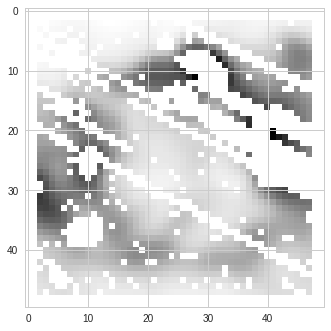

In [36]:
plt.imshow(np.reshape(lori_df['A9'].values,(50,50)))

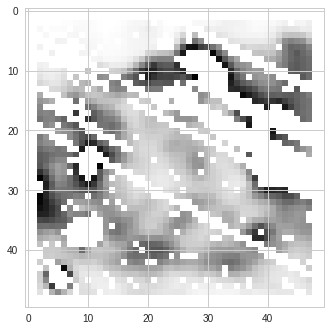

In [37]:
plt.imshow(np.reshape(lori_df['D12'].values,(50,50)))

In [38]:
np.isnan(lori_df_mask['mask'].iloc[6])

True

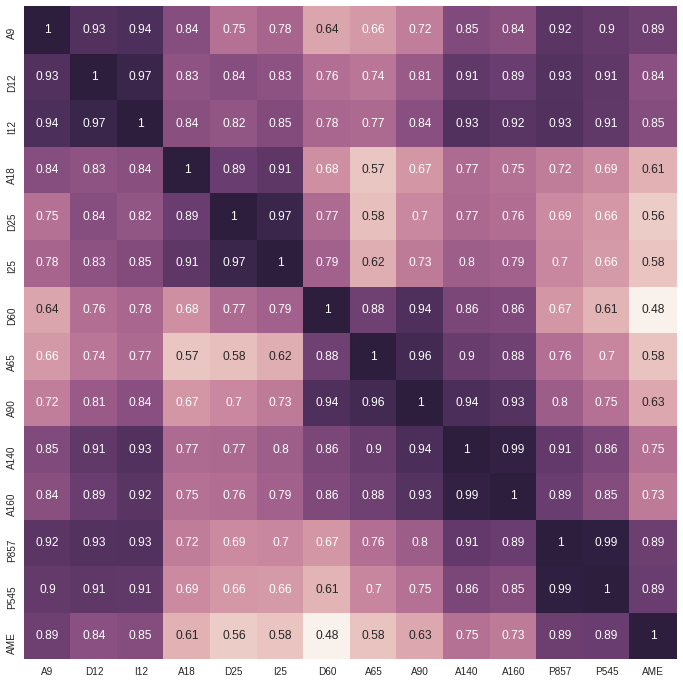

In [39]:
import seaborn as sb
fig = plt.figure(figsize=(12,12))
sb.heatmap(lori_df.corr(method='spearman'), 
           annot=True,
          square=True,
           cbar=False)

fig.savefig('../Plots/png/Allsky_corr_Lori.png')

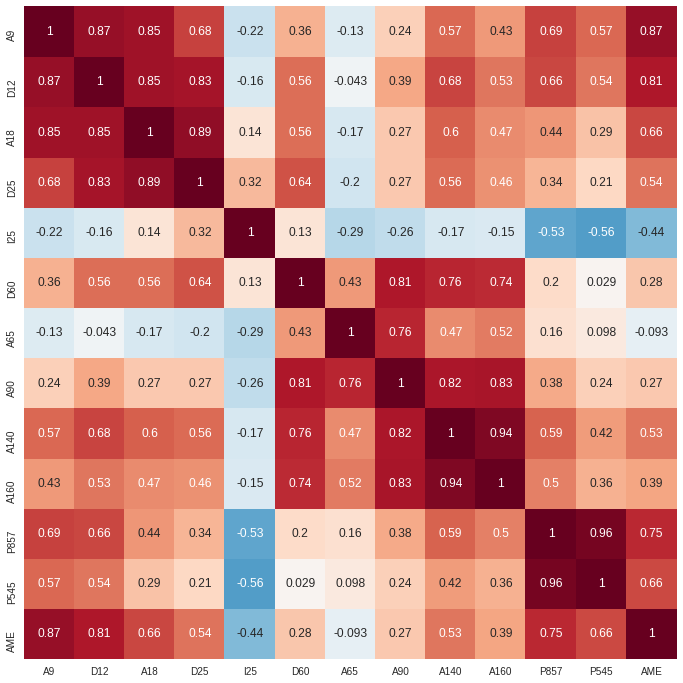

In [86]:
fig = plt.figure(figsize=(12,12))
sb.heatmap(lori_df.drop(['I12','AME'], axis=1).divide(lori_df['I12'],axis=0).join(lori_df['AME']).corr(method='spearman'), 
           annot=True,
          square=True,
           cbar=False)

fig.savefig('../Plots/png/Lori_I12norm_crosscorr.png')
plt.show()


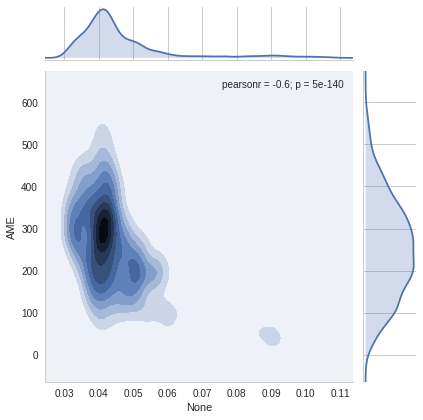

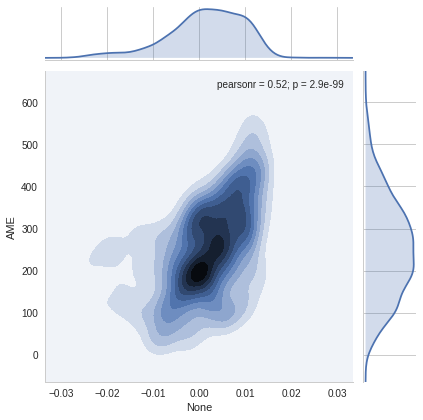

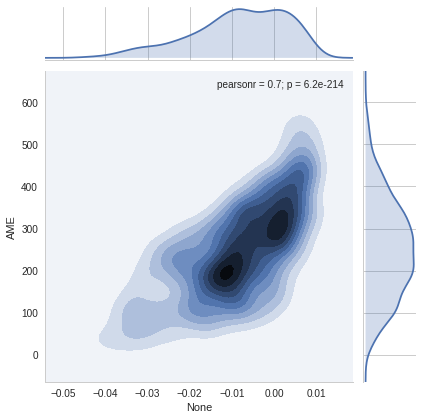

In [40]:
sb.jointplot(lori_df.I25.divide(lori_df.A140,axis=0), lori_df['AME'], dropna=True,kind= "kde")
sb.jointplot(lori_df.D25.divide(lori_df.A140,axis=0), lori_df['AME'], dropna=True,kind= "kde")
fig.csb.jointplot(lori_df.A18.divide(lori_df.A140,axis=0), lori_df['AME'], dropna=True,kind= "kde")

In [97]:
plt.show()

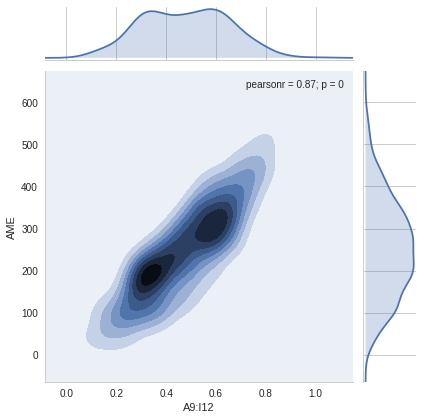

In [98]:
#fig = plt.figure()
a9i12ratio = pd.DataFrame()
a9i12ratio['A9:I12'] = lori_df['A9'].divide(lori_df['I12'],axis=0)
sb.jointplot(a9i12ratio['A9:I12'],
             lori_df['AME'], 
             kind= "kde")
plt.savefig('../Plots/png/Lori_A9I12.png')


ValueError: operands could not be broadcast together with shapes (6250000,) (2500,) 

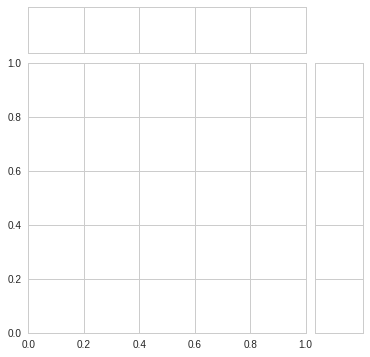

In [50]:
sb.jointplot(pd.DataFrame(lori_df['A9'].divide(lori_df['I12'],axis=0),columns=["A9:I12"]),
             lori_df['AME'], 
             kind= "kde")

MemoryError: 

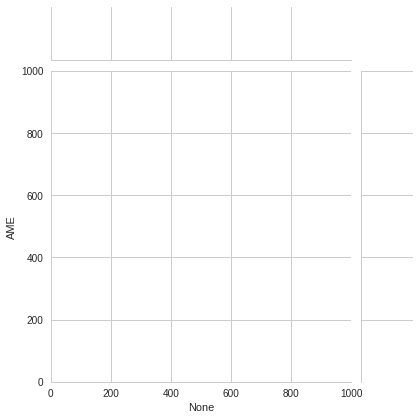

In [46]:
nside = 256

hsize = hp.nside2npix(nside)
    
randsub = np.random.randint(low=0, high=hsize, size=hsize//50)

sb.jointplot(phot_mpsub['A9'].divide(phot_mpsub['I12'],axis=0).iloc[randsub],
             planck_mw['AME'].iloc[randsub], 
             kind= "hex",
            ylim=(0,1000),
            xlim=(0,1000))

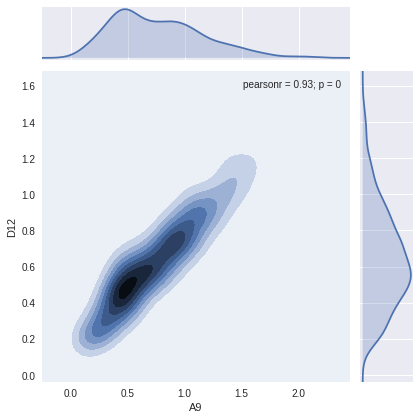

In [66]:
sb.jointplot(lori_df.A9, lori_df['D12'], kind= "kde")

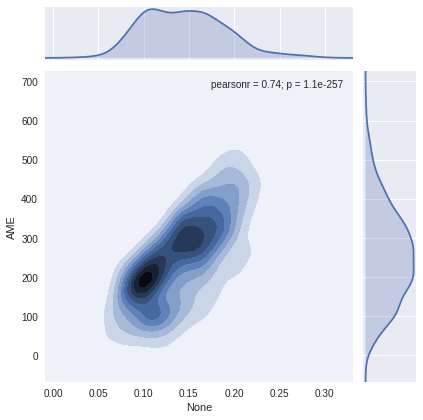

In [67]:
sb.jointplot(lori_df.A9.divide(lori_df['P545'],axis=0),lori_df['AME'], kind= "kde")

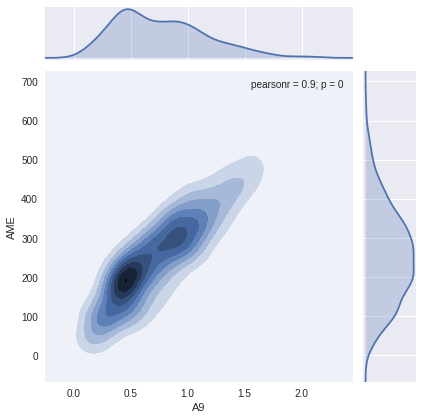

In [63]:
sb.jointplot(lori_df.A9, lori_df['AME'], kind= "kde")

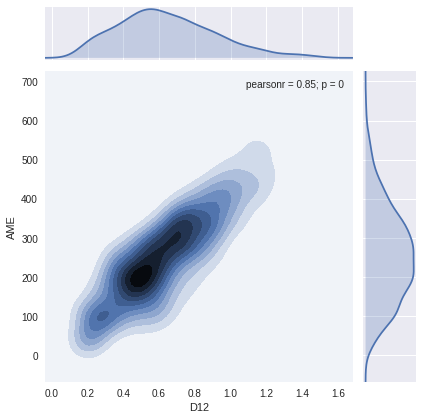

In [68]:
sb.jointplot(lori_df.D12, lori_df['AME'], kind= "kde")